In [52]:
import kagglehub
import librosa

# Download latest version
path = kagglehub.dataset_download("chrisfilo/urbansound8k")

print("Path to dataset files:", path)


Path to dataset files: /Users/sasikala/.cache/kagglehub/datasets/chrisfilo/urbansound8k/versions/1


In [53]:
import os
import pandas as pd

dataset_folder = path  # path is the directory returned by kagglehub.dataset_download

# UrbanSound8K has metadata inside a subfolder named 'metadata' or directly inside
csv_path = None
for root, dirs, files in os.walk(dataset_folder):
    for file in files:
        if file.endswith('.csv'):
            csv_path = os.path.join(root, file)
            break
    if csv_path:
        break

if csv_path:
    print("Found CSV file:", csv_path)
    df = pd.read_csv(csv_path)
    print(df.head(10))
    print(df.columns)
else:
    print("CSV file not found in dataset directory.")


Found CSV file: /Users/sasikala/.cache/kagglehub/datasets/chrisfilo/urbansound8k/versions/1/UrbanSound8K.csv
      slice_file_name    fsID      start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032   0.000000   0.317551         1     5        3   
1  100263-2-0-117.wav  100263  58.500000  62.500000         1     5        2   
2  100263-2-0-121.wav  100263  60.500000  64.500000         1     5        2   
3  100263-2-0-126.wav  100263  63.000000  67.000000         1     5        2   
4  100263-2-0-137.wav  100263  68.500000  72.500000         1     5        2   
5  100263-2-0-143.wav  100263  71.500000  75.500000         1     5        2   
6  100263-2-0-161.wav  100263  80.500000  84.500000         1     5        2   
7    100263-2-0-3.wav  100263   1.500000   5.500000         1     5        2   
8   100263-2-0-36.wav  100263  18.000000  22.000000         1     5        2   
9    100648-1-0-0.wav  100648   4.823402   5.471927         2    10        1   

          

In [54]:
import os

base_dir = "/Users/sasikala/.cache/kagglehub/datasets/chrisfilo/urbansound8k/versions/1"
print(os.listdir(base_dir))


['fold2', 'fold5', 'fold4', 'fold3', 'UrbanSound8K.csv', 'fold8', 'fold6', 'fold1', 'fold7', 'fold9', 'fold10']


In [55]:
def extract_features(row):
    file_path = f"/Users/sasikala/.cache/kagglehub/datasets/chrisfilo/urbansound8k/versions/1/fold{row['fold']}/{row['slice_file_name']}"
    audio, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    mfccs_mean = mfccs.mean(axis=1)
    
    # Optional metadata features
    meta_features = np.array([row['salience'], row['fold']])
    
    combined = np.concatenate((mfccs_mean, meta_features))
    return combined



In [56]:
import numpy as np

X_features = np.array([extract_features(row) for _, row in df.iterrows()])
y = df['classID'].values


/Users/sasikala/Library/Python/3.9/lib/python/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
# One-hot encode the labels
num_classes = len(np.unique(y))
y_encoded = to_categorical(y, num_classes)

model = Sequential([Dense(64,activation = 'relu',kernel_regularizer=l2(0.01),input_shape = (42,)),
                    Dropout(0.2),
                    Dense(32,activation = 'relu',kernel_regularizer=l2(0.01)),
                    Dropout(0.2),
                    Dense(num_classes,activation = 'softmax')
])
# Regularization Method	Main Idea	Code Example	Benefit
# Dropout	Randomly disables neurons	Dropout(0.3)	Prevents co-adaptation
# L2 Regularization	Penalizes large weights	kernel_regularizer=l2(0.001)	Keeps weights small
# Early Stopping	Stops training when val loss worsens	EarlyStopping(...)	Prevents overtraining

model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy',metrics = ['accuracy'])

history = model.fit(X_features , y_encoded , epochs = 30 , batch_size = 32 , validation_split = 0.2)


Epoch 1/30


/Users/sasikala/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1208 - loss: 20.8743 - val_accuracy: 0.0864 - val_loss: 2.9208
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.1443 - loss: 3.0392 - val_accuracy: 0.0996 - val_loss: 2.8110
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - accuracy: 0.1546 - loss: 2.7956 - val_accuracy: 0.1242 - val_loss: 2.7222
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.1597 - loss: 2.6937 - val_accuracy: 0.1265 - val_loss: 2.6497
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.1836 - loss: 2.5762 - val_accuracy: 0.1294 - val_loss: 2.5778
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.2027 - loss: 2.4856 - val_accuracy: 0.1380 - val_loss: 2.5359
Epoch 7/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - accuracy: 0.2095 - loss: 2.4059 - val_accuracy: 0.2421 - val_loss: 2.5002
Epoch 8/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - accuracy: 0.2405 - loss: 2.3145 - val_accuracy

In [58]:
train_loss , train_acc = model.evaluate(X_features,y_encoded)
print("the loss of the train split of the data is ", train_loss)
print("the accuracy of the train split of the data is ", train_acc)

273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.8091 - loss: 0.7988
the loss of the train split of the data is  1.0657027959823608
the accuracy of the train split of the data is  0.731562077999115


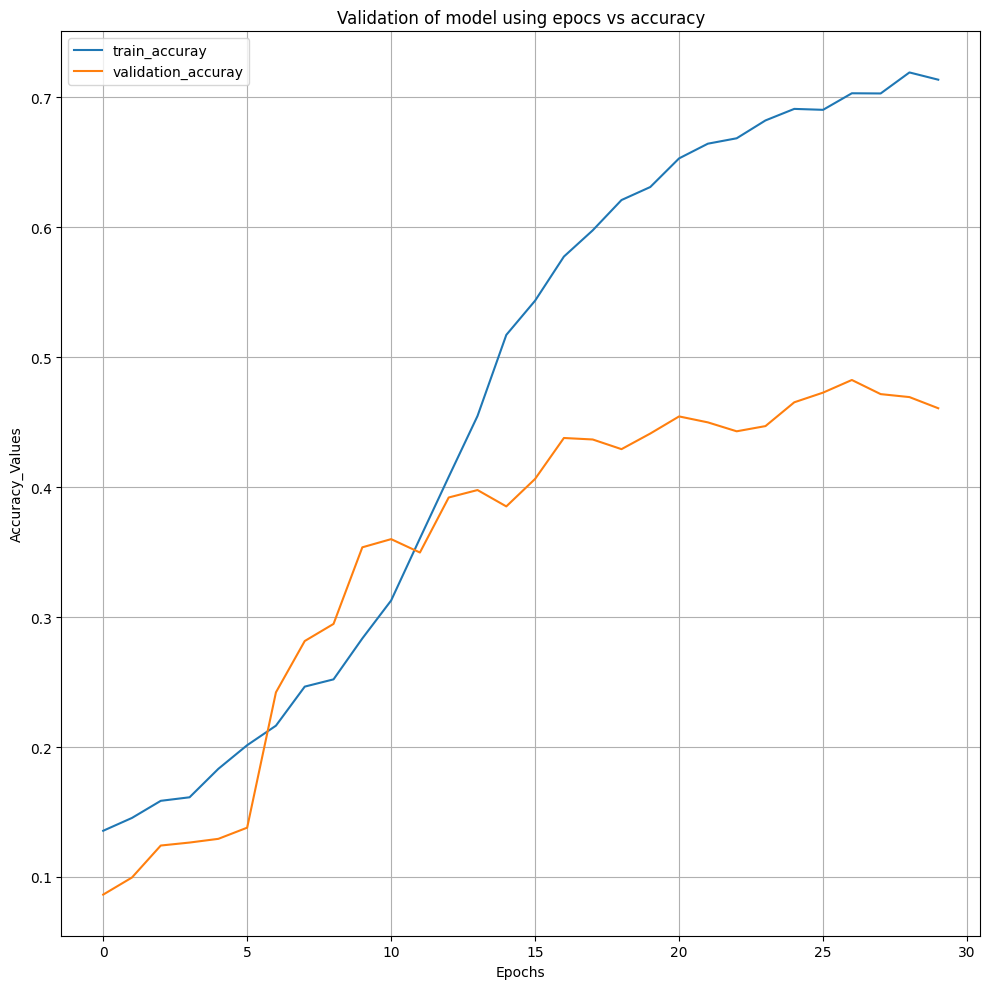

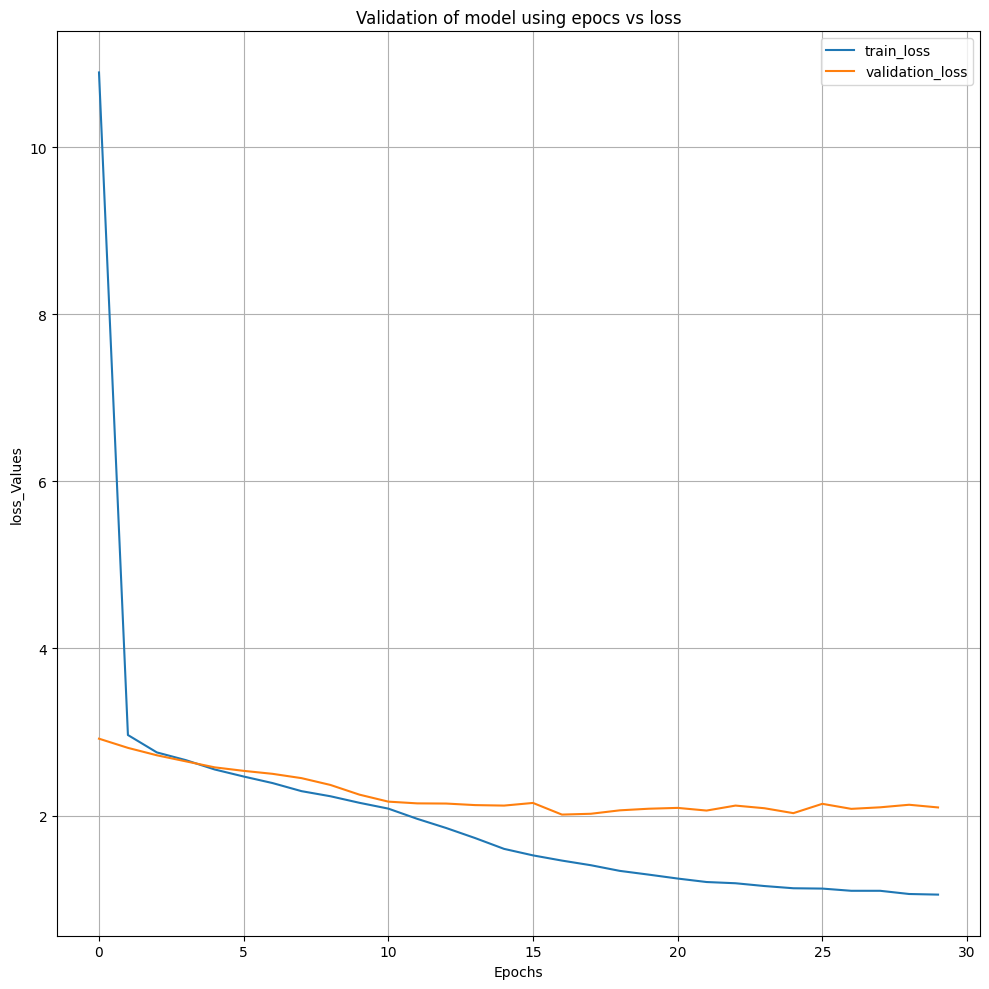

In [59]:
import matplotlib.pyplot as plt
#plotting accuracy
plt.figure(figsize = (10,10))
plt.plot(history.history['accuracy'],label = 'train_accuray')
plt.plot(history.history['val_accuracy'],label = 'validation_accuray')
plt.title("Validation of model using epocs vs accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy_Values')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


#plotting loss

plt.figure(figsize = (10,10))
plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'],label = 'validation_loss')
plt.title("Validation of model using epocs vs loss")
plt.xlabel('Epochs')
plt.ylabel('loss_Values')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [60]:
model.save('/Users/sasikala/Desktop/github folder/Machine_Learning/urban_app.h5')
